# Worked All OARC

## Setup

### Imports

First we do all of our imports. Ideally we import in alphabetical order, and I wish there was a way to generate `requirements.txt` from it directly.

I also detect if running on Google Colab as I need to import from here...

In [50]:
import os

if 'COLAB_GPU' in os.environ:
    !pip install ctyparser maidenhead ipyleaflet ipywidgets pyhamtools
    from google.auth import default
    from google.colab import auth, drive
    from googleapiclient.http import MediaIoBaseDownload
    from googleapiclient.discovery import build

import ctyparser
import gspread as gs
import ipywidgets as widgets
import maidenhead as mh
import matplotlib
import pandas as pd
import re
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, MarkerCluster
from ipywidgets import interact, interact_manual
from pyhamtools import LookupLib, Callinfo


### Setup pyhamtools

Little bit of set up for DXCC cleaning

In [51]:
my_lookuplib = LookupLib(lookuptype='countryfile')
cic = Callinfo(my_lookuplib)

### Set up Google Sheet credentials

Some nasty little tricks needed here:

1. For local environment, we use a .json file in the parent so it won't be pushed to github
1. For Netlify deployment, we detect it by reading the Environment Variable `NETLIFY`
   1. Then we read all the env vars into a dictionary
   2. We have to replace all the `'\\n'` with `'\n'` as the extra `'\'` gets added
1. Then we get access to the Google Sheet

In [2]:
def create_keyfile_dict():
    variables_keys = {
       "type": os.getenv("TYPE"),
       "project_id": os.getenv("PROJECT_ID"),
       "private_key_id": os.getenv("PRIVATE_KEY_ID"),
       "private_key": os.getenv("PRIVATE_KEY").replace("\\n", "\n"),
       "client_email": os.getenv("CLIENT_EMAIL"),
       "client_id": os.getenv("CLIENT_ID"),
       "auth_uri": os.getenv("AUTH_URI"),
       "token_uri": os.getenv("TOKEN_URI"),
       "auth_provider_x509_cert_url": os.getenv("AUTH_PROVIDER_X509_CERT_URL"),
       "client_x509_cert_url": os.getenv("CLIENT_X509_CERT_URL")
    }
    return variables_keys
if os.environ.get('NETLIFY'):
    gc = gs.service_account_from_dict(create_keyfile_dict())
    sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1dpciJGykIvwxHWgWrw_KTVi10EisyUZ6cah962oaStI/edit?usp=sharing')
    ws = sh.worksheet('Form responses 1')
elif 'COLAB_GPU' in os.environ:
    auth.authenticate_user()
    creds, _ = default()
    gc = gs.authorize(creds)
    sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1dpciJGykIvwxHWgWrw_KTVi10EisyUZ6cah962oaStI/edit?usp=sharing')
    ws = sh.worksheet('Form responses 1')
else:
    gc = gs.service_account(filename='../workedalloarc-53ba91a71aa2.json')
    sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1dpciJGykIvwxHWgWrw_KTVi10EisyUZ6cah962oaStI/edit?usp=sharing')
    ws = sh.worksheet('Form responses 1')

### Load all the records

Our assumption zero is that all the data is dirty and not to be trusted. Even validation isn't perfect.
So we load it in first.

We also make a dfclean into which we will create a 'clean' set of QSOs. We will generate a series of error rows too

In [18]:
df = pd.DataFrame(ws.get_all_records())
dfclean = df.copy()
df.head(10)

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details
0,26/04/2022 20:34:04,27/04/2022 12:23:00,M0SMU,M7SMU,144 MHz (2m),FM,IO81oj,IO81ql,EU-005,Not innovative at all,test
1,26/04/2022 20:34:35,19/04/2022 09:00:00,M0SMU,2E0UMS,7 MHz (40m),SSB,,,,,
2,26/04/2022 20:37:12,24/04/2021 11:00:00,2e0ggj,m0nvk,7 MHz (40m),SSB,io95fb,m0nvk home qth,,Ran one or two full courses :-),Am a good egg !
3,26/04/2022 20:39:58,20/03/2022 19:31:00,mojqq,m0lte,7 MHz (40m),Olivia,io95ec,nk,,,
4,26/04/2022 20:41:07,26/04/2022 15:30:00,m0jqq,m0smu,144 MHz (2m),DMR,none,none,,,
5,26/04/2022 22:18:00,26/04/2022 22:04:00,M0SMU,2EØVCC/P,144 MHz (2m),SSB,,,,,
6,27/04/2022 12:27:40,27/04/2022 12:24:00,EI5IYB /P,M0SMU,Gamma Wave,Telepathy93,IO63we,IO81oj,Brain Waves,Well...,Detailed details
7,29/04/2022 11:28:11,28/04/2022 09:00:00,2E0UMS,M0OUK,144 MHz (2m),SSB,IO81oj,,,,
8,29/04/2022 23:14:57,28/04/2022 21:22:00,EI5IYB,TF2MSN,7 MHz (40m),FT8,,,,,
9,29/04/2022 23:18:41,29/04/2022 22:17:00,EI5IYB,IW9FRA,7 MHz (40m),FT8,IO63,JM68,,,


## Cleaning up the data

### Callsigns

So the first job is to clean up the callsigns, you can't have a QSO without two valid callsigns!

I've found a good regex to split out a callsign into components (prefix, letters, number, letters, suffix), but as we will see later, that isn't enough to extract the DXCC from a callsign.

In [19]:
# Next we clean the callsigns up and find any prefix / suffix and the DXCC
regex = re.compile('^([A-Z0-9]+[\/])?([A-Z][0-9]|[A-Z]{1,2}|[0-9][A-Z])([0-9]|[0-9]+)([A-Z]+)([\/][A-Z0-9]+)?')
df['Your Callsign Clean'] = df['Your Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
df['Your DXCC'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[1]
df['Your Prefix'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[0]
df['Your Suffix'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[4]
df['Their Callsign Clean'] = df['Their Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
df['Their DXCC'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[1]
df['Their Prefix'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[0]
df['Their Suffix'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[4]
df.head(10)


,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details,Your Callsign Clean,Your DXCC,Your Prefix,Your Suffix,Their Callsign Clean,Their DXCC,Their Prefix,Their Suffix
0,26/04/2022 20:34:04,27/04/2022 12:23:00,M0SMU,M7SMU,144 MHz (2m),FM,IO81oj,IO81ql,EU-005,Not innovative at all,test,M0SMU,M,NaN,NaN,M7SMU,M,NaN,NaN
1,26/04/2022 20:34:35,19/04/2022 09:00:00,M0SMU,2E0UMS,7 MHz (40m),SSB,,,,,,M0SMU,M,NaN,NaN,2E0UMS,2E,NaN,NaN
2,26/04/2022 20:37:12,24/04/2021 11:00:00,2e0ggj,m0nvk,7 MHz (40m),SSB,io95fb,m0nvk home qth,,Ran one or two full courses :-),Am a good egg !,2E0GGJ,2E,NaN,NaN,M0NVK,M,NaN,NaN
3,26/04/2022 20:39:58,20/03/2022 19:31:00,mojqq,m0lte,7 MHz (40m),Olivia,io95ec,nk,,,,MOJQQ,NaN,NaN,NaN,M0LTE,M,NaN,NaN
4,26/04/2022 20:41:07,26/04/2022 15:30:00,m0jqq,m0smu,144 MHz (2m),DMR,none,none,,,,M0JQQ,M,NaN,NaN,M0SMU,M,NaN,NaN
5,26/04/2022 22:18:00,26/04/2022 22:04:00,M0SMU,2EØVCC/P,144 MHz (2m),SSB,,,,,,M0SMU,M,NaN,NaN,2E0VCC/P,2E,NaN,/P
6,27/04/2022 12:27:40,27/04/2022 12:24:00,EI5IYB /P,M0SMU,Gamma Wave,Telepathy93,IO63we,IO81oj,Brain Waves,Well...,Detailed details,EI5IYB/P,EI,NaN,/P,M0SMU,M,NaN,NaN
7,29/04/2022 11:28:11,28/04/2022 09:00:00,2E0UMS,M0OUK,144 MHz (2m),SSB,IO81oj,,,,,2E0UMS,2E,NaN,NaN,M0OUK,M,NaN,NaN
8,29/04/2022 23:14:57,28/04/2022 21:22:00,EI5IYB,TF2MSN,7 MHz (40m),FT8,,,,,,EI5IYB,EI,NaN,NaN,TF2MSN,TF,NaN,NaN
9,29/04/2022 23:18:41,29/04/2022 22:17:00,EI5IYB,IW9FRA,7 MHz (40m),FT8,IO63,JM68,,,,EI5IYB,EI,NaN,NaN,IW9FRA,IW,NaN,NaN


### Clean up callsigns in dfclean

Remove suffix and have suffix in another column (My Suffix, Their Suffix)

In [20]:
dfclean['Your Callsign'] = dfclean['Your Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
#df['Your DXCC'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[1]
dfclean['Your Prefix'] = dfclean['Your Callsign'].str.extract(regex, expand=True)[0]
dfclean['Your Suffix'] = dfclean['Your Callsign'].str.extract(regex, expand=True)[4]
dfclean['Their Callsign'] = dfclean['Their Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
#df['Their DXCC'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[1]
dfclean['Their Prefix'] = dfclean['Their Callsign'].str.extract(regex, expand=True)[0]
dfclean['Their Suffix'] = dfclean['Their Callsign'].str.extract(regex, expand=True)[4]
dfclean.head(10)

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details,Your Prefix,Your Suffix,Their Prefix,Their Suffix
0,26/04/2022 20:34:04,27/04/2022 12:23:00,M0SMU,M7SMU,144 MHz (2m),FM,IO81oj,IO81ql,EU-005,Not innovative at all,test,NaN,NaN,NaN,NaN
1,26/04/2022 20:34:35,19/04/2022 09:00:00,M0SMU,2E0UMS,7 MHz (40m),SSB,,,,,,NaN,NaN,NaN,NaN
2,26/04/2022 20:37:12,24/04/2021 11:00:00,2E0GGJ,M0NVK,7 MHz (40m),SSB,io95fb,m0nvk home qth,,Ran one or two full courses :-),Am a good egg !,NaN,NaN,NaN,NaN
3,26/04/2022 20:39:58,20/03/2022 19:31:00,MOJQQ,M0LTE,7 MHz (40m),Olivia,io95ec,nk,,,,NaN,NaN,NaN,NaN
4,26/04/2022 20:41:07,26/04/2022 15:30:00,M0JQQ,M0SMU,144 MHz (2m),DMR,none,none,,,,NaN,NaN,NaN,NaN
5,26/04/2022 22:18:00,26/04/2022 22:04:00,M0SMU,2E0VCC/P,144 MHz (2m),SSB,,,,,,NaN,NaN,NaN,/P
6,27/04/2022 12:27:40,27/04/2022 12:24:00,EI5IYB/P,M0SMU,Gamma Wave,Telepathy93,IO63we,IO81oj,Brain Waves,Well...,Detailed details,NaN,/P,NaN,NaN
7,29/04/2022 11:28:11,28/04/2022 09:00:00,2E0UMS,M0OUK,144 MHz (2m),SSB,IO81oj,,,,,NaN,NaN,NaN,NaN
8,29/04/2022 23:14:57,28/04/2022 21:22:00,EI5IYB,TF2MSN,7 MHz (40m),FT8,,,,,,NaN,NaN,NaN,NaN
9,29/04/2022 23:18:41,29/04/2022 22:17:00,EI5IYB,IW9FRA,7 MHz (40m),FT8,IO63,JM68,,,,NaN,NaN,NaN,NaN


### WIP - DXCC parsing

I'm using [ctyparser](https://github.com/miaowware/ctyparser) to find DXCC. This requires using a `cty.dat` file, that I'm hosting in the github rep. I could point at it, but I'd rather control it and update it when I have time to test any changes.

In [6]:
# Check the DXCC is valid
cty = ctyparser.BigCty()
if 'COLAB_GPU' in os.environ:
    drive.mount('/content/drive')
    cty.import_dat('/content/drive/My Drive/Python imports/WAOARC/cty.dat')
else:
    cty.import_dat('cty.dat')
#df['Valid Your DXCC'] = df['Your DXCC'].isin(cty.keys())
#df['Valid Their DXCC'] = df['Their DXCC'].isin(cty.keys())
#print(cty['VK'])
#dxccs = {}
#for dx in cty.items():
#    dxccs[dx[0]] = dx[1]['entity']
#df['Full Your DXCC'] = df['Your DXCC'].map(dxccs)
#df['Full Their DXCC'] = df['Their DXCC'].map(dxccs)
#df.head(10)

### DXCC parsing - a worked example

Let's look at the callsign IW9AAB

In [7]:
#print(cty['IW9'])
search_key = 'IW9AAB'
for idx in range(len(search_key)):
    if idx == 0:
        short_key = search_key
    else:
        short_key = search_key[:-(idx)]
    print(short_key)
    res = [val for key, val in cty.items() if short_key in key]
    if res != []:
        a_key = 'entity'
        values_of_key = [a_dict[a_key] for a_dict in res]
        break
print(values_of_key)

IW9AAB
IW9AA
IW9A
IW9
['Italy', 'Sicily (not DXCC)']


### Clean DXCC

We want to extract the DXCC for dfclean callsigns

In [53]:
def cleandxcc(callsign):
    '''returns the DXCC for a callsign'''
    return cic.get_country_name(callsign)


print(cleandxcc('IW9AAB'))
print(cleandxcc('M7SMU'))
print(cleandxcc('EI5IYB/P'))

Sicily
England
Ireland


## Example interaction

### Show 'my' QSOs

Note this is disabled in Netlify (as it doesn't work...)

In [8]:
if os.environ.get('NETLIFY'):
    print("Sadly we can't do interactivity in Netlify environment - I need to find a work around")
else:
    @interact
    def show_my_QSO(Callsign = df['Your Callsign Clean'].unique()):
        return df.loc[df['Your Callsign Clean'].values==Callsign]

interactive(children=(Dropdown(description='Callsign', options=('M0SMU', '2E0GGJ', 'MOJQQ', 'M0JQQ', 'EI5IYB/P…

### Show QSOs by Band and Mode

In [9]:
print(df['Band'].unique())
print(df['Mode'].unique())
if os.environ.get('NETLIFY'):
    print("Sadly we can't do interactivity in Netlify environment - I need to find a work around")
else:
    @interact
    def show_by_band_mode(Band = df['Band'].unique(), Mode = df['Mode'].unique()):
        return df.loc[(df['Band'].values==Band) & (df['Mode'].values==Mode)]

['144 MHz (2m)' '7 MHz (40m)' 'Gamma Wave']
['FM' 'SSB' 'Olivia' 'DMR' 'Telepathy93' 'FT8']


interactive(children=(Dropdown(description='Band', options=('144 MHz (2m)', '7 MHz (40m)', 'Gamma Wave'), valu…

## Plotting some graphs

Text(0, 0.5, 'Band')

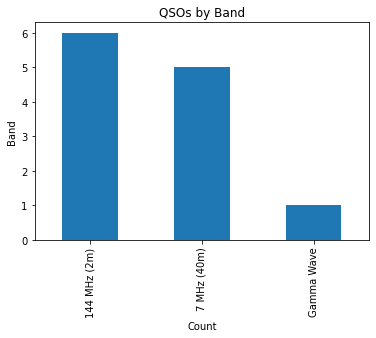

In [10]:
bandplot = df['Band'].value_counts().plot(kind = 'bar')
bandplot.set_title('QSOs by Band')
bandplot.set_xlabel('Count')
bandplot.set_ylabel('Band')

Text(0, 0.5, 'Mode')

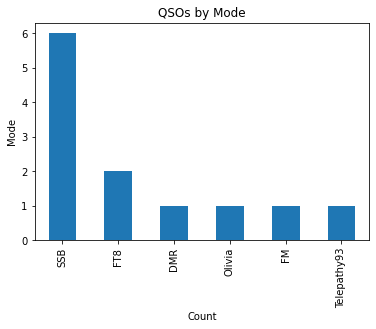

In [11]:
modeplot = df['Mode'].value_counts().plot(kind = 'bar')
modeplot.set_title('QSOs by Mode')
modeplot.set_xlabel('Count')
modeplot.set_ylabel('Mode')

Text(0, 0.5, 'Callsign')

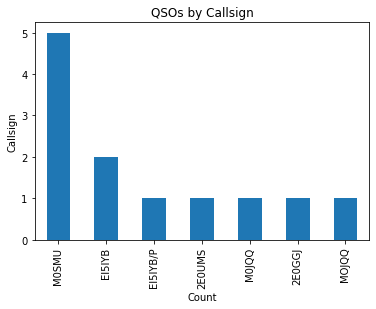

In [12]:
callplot = df['Your Callsign Clean'].value_counts().plot(kind = 'bar')
callplot.set_title('QSOs by Callsign')
callplot.set_xlabel('Count')
callplot.set_ylabel('Callsign')

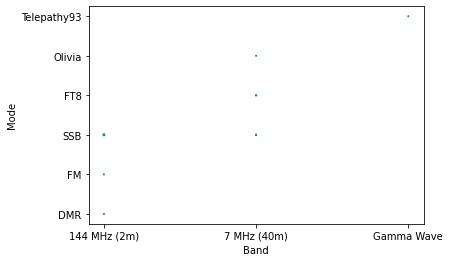

In [13]:
bandmodeplot = df.groupby(['Band','Mode']).size().reset_index(name='count').plot.scatter(x='Band', y='Mode', s='count')

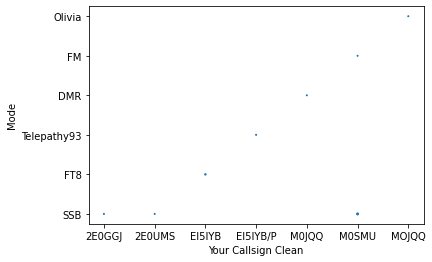

In [14]:
callsignmodeplot = df.groupby(['Your Callsign Clean','Mode']).size().reset_index(name='count').plot.scatter(x='Your Callsign Clean', y='Mode', s='count')

## Mapping

This notebook uses ipyleaflet maps

In [15]:
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=(48.204, 350.121),
    zoom=3
    )
m

Map(center=[48.204, 350.121], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [16]:
qth = []
for i in range(len(df)):
    if len(df.iloc[i]['Locator Sent'])>4:
        qth.append([mh.to_location(df.iloc[i]['Locator Sent'])[0],
                    mh.to_location(df.iloc[i]['Locator Sent'])[1]])
Test_map = Map(basemap=basemaps.Stamen.Toner, center = [51, -2], zoom = 3)
list_of_markers = [Marker(location=x, draggable=False) for x in qth]
Test_map.add_layer(MarkerCluster(markers=list_of_markers));
display(Test_map)

Map(center=[51, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…